
# ¿Qué problemas son posibles resolver?

En este notebook aprenderemos a determinar *qué* problemas son abordables por heurísticas. En específico, veremos la diferencia en atacar los problemas polinomiales (P) y no determinísticos polinomiales (NP). En efecto, si $\pi$ es un problema NP-completo y encontramos una forma polinomial de resolverlo, habríamos probado unos de los problemas del milenio. 

Para este ejercicio trabajaremos con el problema del ***Minimum Spanning Tree***, utilizado frecuentemente en el problema del **vendedor viajero**. Dado un grafo ponderado no dirigido $R=(V,E,w)$ en un conjunto $V$ de vertices, $E$ de aristas con una función $w\to\mathbb{R}$ de pesos, buscamos un subgrafo **conectado**, **sin ciclos** cuyo peso total sea el **mínimo posible**. Su formulación simple es la siguiente: 

$$
\begin{align}
\min z&=\sum_{e\in E}w(e)x_e \\ \\
\sum_{e\in E}x_e&=\lvert V\rvert - 1\\ \\
\sum_{e\in E(S)}x_e&\leq\lvert S\rvert - 1\;\;\forall S\subseteq V, S\neq\emptyset\\ \\
x_e&\in\lbrace 0,1\rbrace\;\;\forall e\in E
\end{align}
$$

Por el otro lado, trabajaremos con la librería `networkx` para poder visualizar los problemas entre grafos. A continuación, un breve tutorial sobre cómo trabajar con aquella librería. Pueden saltar la sección en caso de saber dominarla.

## Utilización de networkx

`networkx` es una biblioteca de Python para estudiar grafos y analizar redes. Es ampliamente utilizado para distintos objetivos, entre ellos, visualizaciones, análisis de redes sociales o simulaciones. Es código abierto y mantenida activamente por una comunidad grande de programadores. 

### Creación de un grafo

Para poder crear un grafo, llamaremos a la función inicializadora

In [55]:
import networkx as nx

G = nx.Graph()

Es posible añadir nodos de varias formas. Para hacerlo, utilizaremos los siguientes métodos: 

- `add_node`: Añade un nodo singular, indexado por un ID que puede ser un string o entero.
- `add_nodes_from`: Añadir nodos a partir de una lista.


In [76]:
G.add_node(1)  # Añadir nodo con id "1"
G.add_node("A")  # Añadir nodo con id "A"
G.add_nodes_from([2, 3, 4])  # Añadir nodo a partir de una lista

De forma adicional, es posible añadir los nodos con el **id**, y **atributos** de una pasada directa. Los atributos pueden ser otorgados arbitrariamente por nosotros.

In [84]:
G.add_nodes_from(
    [
        (11, {"color": "red", "size": 20}),
        (12, {"color": "blue", "pos": (2.0, 5.0)}),
    ]
)

De la misma forma, es posible eliminar nodos por su ID.

In [78]:
G.remove_node("A")

De la misma forma, es posible añadir aristas con el método `add_edge`. Se utiliza el atributo `weight` para añadirla con peso. 

In [79]:
G.add_edge(1, 3, weight=2.5)  # (Nodo de origen, nodo de destino, peso)

También se puede hacer como lista, de forma similar a `add_nodes_from`

In [90]:
G.add_edges_from(
    [
        (3, 11, {"weight": 1}),
        (11, 12, {"weight": 5}),
        (4, 3, {"weight": 3.5}),
        (2, 1, {"weight": 0.5}),
    ]
)

### Visualización

Para plotear el gráfico es posible utilizar `matplotlib`. `networkx` ofrece métodos para poder dibujar sus grafos de forma simple.

Primero, el grafo debe tener una **posición**. Existe una teoría extensa por detrás de las posiciones a utilizar en los grafos. La más simple es imponer un `spring_layout`.

In [81]:
posicion = nx.spring_layout(G, seed=42)

Es posible llamar la función `draw` para poder dibujar el grafo `G` con su posición `posicion`. Existen muchos otros atributos que pueden ser consultados [aquí](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw).

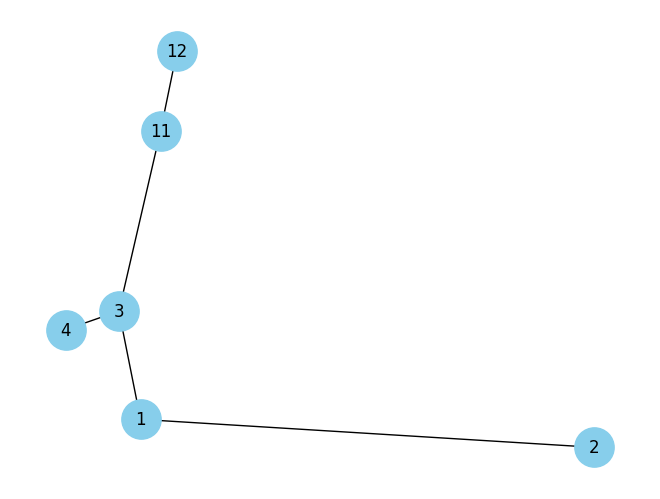

In [91]:
nx.draw(
    G, posicion, with_labels=True, node_color="skyblue", node_size=800, font_size=12
)

Al gráfico lo podemos complementar al añadir etiquetas a las aristas. En ese sentido, es posible añadir las etiquetas en función de los atributos `"weight"` que nos definimos anteriormente.

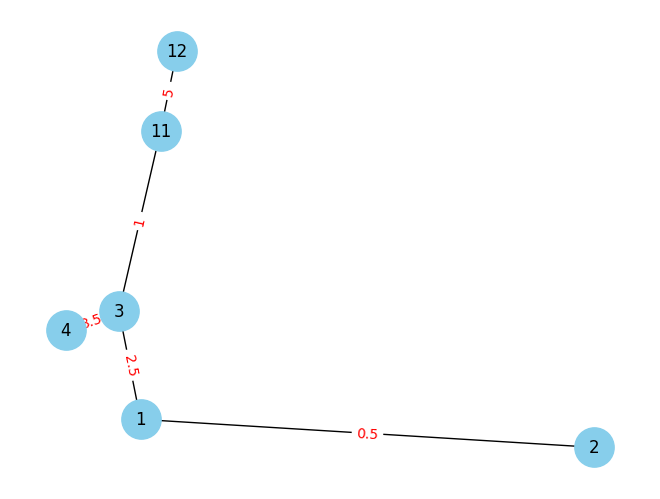

In [93]:
nx.draw(
    G, posicion, with_labels=True, node_color="skyblue", node_size=800, font_size=12
)
nx.draw_networkx_edge_labels(
    G, posicion, edge_labels=nx.get_edge_attributes(G, "weight"), font_color="red"
)

plt.show()

## Aplicación: creando nuestro primer ***minimum spanning tree***

Asumamos que somos un emprendedor cafetero, basado en Buenos Aires, que debe hacer un recorrido por toda las cafeterias de la ciudad para reabastecer los negocios. Claramente, lo ideal sería recorrer todas las cafeterías en el menor tiempo posible. Por lo mismo, decide generar un grafo ponderado con las ubicaciones de las cafeterias principales de la ciudad.

Para lograr aquello, generan la función `obtenerGrafo`, que devuelve un grafo del tipo `networkx`. Además, tienen la función `graficar` que muestra los puntos de interés en el mapa de Buenos Aires.

In [322]:
import osmnx as ox
import numpy as np

ox.settings.use_cache = True
ox.settings.log_console = False


import osmnx as ox
import networkx as nx
import numpy as np

# -----
# Configuración de OSMnx
# -----
ox.settings.use_cache = True
ox.settings.log_console = False


def obtenerGrafo(
    cantidadNodos,
    puntoInteres,
    ciudad="Ciudad Autónoma de Buenos Aires, Argentina",
    seed=42,
    noise_level=0.7,  # δ: ruido multiplicativo uniforme en [1-δ, 1+δ]
):
    """
    Descarga la red vial de la ciudad y genera un grafo completo entre POIs,
    usando pesos reales perturbados con ruido multiplicativo.

    Parámetros:
    ----------
    cantidadNodos : int
        Número de puntos de interés a utilizar.
        - Si hay más puntos de los indicados, se toma una muestra aleatoria.
        - Si la cantidad disponible es menor o igual, se usan todos.

    puntoInteres : str
        Tipo de punto de interés según la etiqueta "amenity" de OpenStreetMap.
        Ejemplos:
            - "cafe"
            - "restaurant"
            - "bank"
            - "pharmacy"

    ciudad : str
        La ciudad a obtener el mapa, por defecto, Buenos Aires.

    seed : int
        Semilla para el muestreo aleatorio y el ruido.

    noise_level : float
        Nivel de ruido multiplicativo (0.2 → ±20% sobre el valor real).

    Retorna:
    -------
    K : networkx.Graph
        Grafo completo con N nodos (POIs) y pesos ruidosos.
    """
    rng = np.random.default_rng(seed)

    # -----
    # 1) Descargar red vial y añadir velocidad y tiempo estimado
    # -----
    G = ox.graph_from_place(ciudad, network_type="drive", simplify=True)
    G = ox.add_edge_speeds(G)  # km/h estimado
    G = ox.add_edge_travel_times(G)  # segundos estimados

    # -----
    # 2) Obtener puntos de interés y muestrear
    # -----
    tags = {"amenity": puntoInteres}
    pois = ox.features_from_place(ciudad, tags=tags)
    pois = pois[pois.geometry.type == "Point"].reset_index(drop=True)
    pois = pois.sample(min(cantidadNodos, len(pois)), random_state=seed).reset_index(
        drop=True
    )
    lats = pois.geometry.y.values
    lons = pois.geometry.x.values
    poi_nodes = ox.nearest_nodes(G, lons, lats)
    N = len(pois)

    # -----
    # 3) Construir grafo completo optimizado
    #     - Usamos N corridas de single-source Dijkstra en lugar de ~N²
    #     - Añadimos ruido multiplicativo a cada peso
    # -----
    def dists_from(src):
        try:
            return nx.single_source_dijkstra_path_length(
                G, source=src, weight="travel_time"
            )
        except Exception:
            return nx.single_source_dijkstra_path_length(G, source=src, weight="length")

    K = nx.complete_graph(N)
    for i in range(N):
        dist_i = dists_from(poi_nodes[i])  # una sola corrida desde i
        for j in range(i + 1, N):
            base_w = float(dist_i[poi_nodes[j]])
            noisy_w = base_w * rng.uniform(1.0 - noise_level, 1.0 + noise_level)
            K.add_edge(i, j, weight=noisy_w)

    # -----
    # 4) Guardar metadatos para graficar después
    # -----
    K.graph["poi_nodes"] = poi_nodes
    K.graph["city"] = ciudad
    K.graph["pos"] = {
        i: (G.nodes[poi_nodes[i]]["x"], G.nodes[poi_nodes[i]]["y"]) for i in range(N)
    }

    return K


def graficar(K, ciudad="Ciudad Autónoma de Buenos Aires, Argentina", labels=True):
    """
    Grafica el grafo actual, posicionado con respecto al mapa de Buenos Aires.

    Parámetros:
    ----------
    K: networkx.MultiDiGraph
        Grafo con los puntos de intereses, habiendo sido obtenido con `obtenerGrafo`.

    ciudad : str
        La ciudad a graficar y posicionar los nodos del grafo
    """
    # -----
    # Descargamos la red vial de Buenos Aires con la velocidad y tiempo de recorrido
    # -----
    city_bg = ciudad or K.graph.get(
        "city", "Ciudad Autónoma de Buenos Aires, Argentina"
    )
    G = ox.graph_from_place(city_bg, network_type="drive", simplify=True)
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)

    # -----
    # Obtenemos la posición en función de la posición del mapa de Buenos Aires
    # -----
    pos = K.graph["pos"]

    # -----
    # Parámetros del dibujo, como ancho de aristas y etiquetas
    # -----
    weights = [d["weight"] for _, _, d in K.edges(data=True)]
    wmin, wmax = min(weights), max(weights)
    eps = 1e-9
    edge_widths = [1.0 + 3.0 * (wmax - w) / (wmax - wmin + eps) for w in weights]
    edge_labels = {(i, j): f"{K[i][j]['weight']/60:.1f} min" for i, j in K.edges()}

    # -----
    # Dibujar el mapa de Buenos Aires
    # -----
    fig, ax = ox.plot_graph(
        G,
        node_size=0,
        edge_color="#d9d9d9",  # Gris
        edge_linewidth=0.6,
        bgcolor="white",
        show=False,
        close=False,
    )

    # -----
    # Dibujar el grafo
    # -----
    # Dibujar aristas
    nx.draw_networkx_edges(
        K, pos, ax=ax, width=edge_widths, edge_color="tab:blue", alpha=0.25
    )
    # Dibujar nodos
    nx.draw_networkx_nodes(
        K,
        pos,
        ax=ax,
        node_size=40,
        node_color="crimson",
        edgecolors="white",
        linewidths=0.8,
    )
    # Etiquetas de los nodos
    nx.draw_networkx_labels(K, pos, ax=ax, font_size=8)
    # Etiquetas de las aristas
    if labels:
        nx.draw_networkx_edge_labels(
            K, pos, ax=ax, edge_labels=edge_labels, font_size=7, rotate=False
        )

    plt.tight_layout()
    plt.show()

Así, es posible visualizar las tiendas de interés con la función `graficar`

In [304]:
G = obtenerGrafo(200, "cafe")

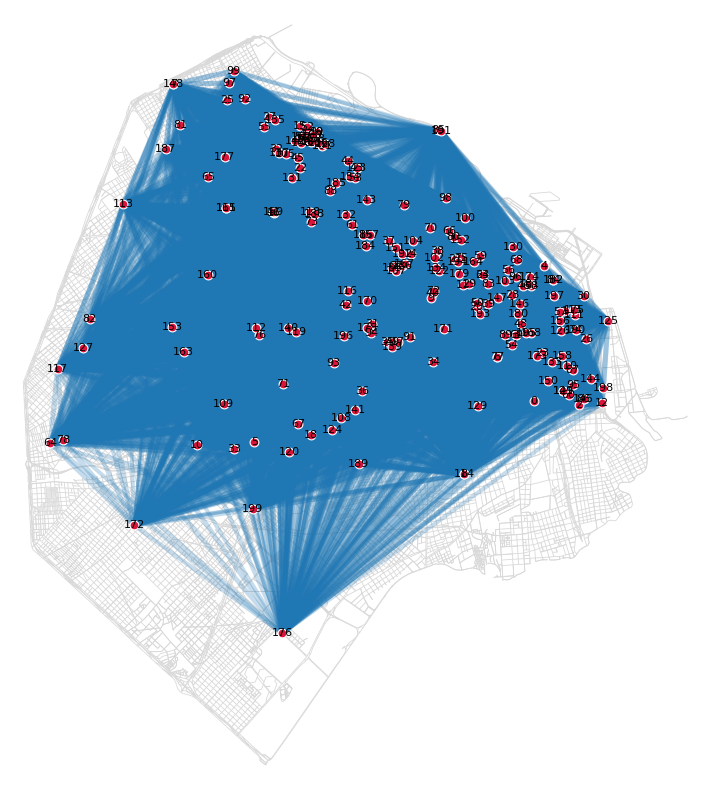

In [306]:
graficar(G, labels=False)

Para obtener el ***minimum spanning tree*** requerirán programar algunos de los métodos exactos (**sin utilizar** el que ya viene implementado en `networkx`, más adelante verán por qué) (pueden elegir programar sólo uno)

### Algoritmo de Kruskal

El algoritmo de Kruskal consiste en las siguientes instrucciones: 

1. Ordenar las aristas del grafo de menor a mayor peso.

2. Crear grupos independientes: la idea es que al inicio, cada nodo está **sólo**. Para poder agregar un nodo a un conjunto, utilizamos la función `union`. La idea es que un conjunto se puede unir a otro **solámente** si no estaba previamente en el grupo. Por ejemplo, supongamos que tenemos los conjuntos: $\lbrace A, \rbrace, \lbrace B \rbrace, \lbrace C\rbrace, \lbrace D\rbrace$. Si queremos agregar una arista $(A,B)$, entonces es necesario unir los grupos tal que $\lbrace A, B\rbrace, \lbrace C\rbrace, \lbrace D\rbrace$. Luego, si agregamos la arista $(B,C)$ el conjunto se expande a $\lbrace A, B, C\rbrace, \lbrace D\rbrace$. Sin embargo, si quisieramos añadir la arista $(A,C)$ no se podría, ya que $A$ y $C$ ya pertenecen al conjunto.

3. Recorrer las aristas en orden creciente: Ir recorriendo las aristas en base al peso de cada una de ellas. Al intentar añadir una arista, hay que ver si es posible añadirla al conjunto principal (operación `find`) según las reglas del paso 2. En caso de poder, unirlas con la función `union`.


Completen la siguiente función que programa el algoritmo de Kruskal

In [317]:
import networkx as nx


def kruskal(G):
    """
    Dado un grafo, retorna una tupla con:
      - Un subgrafo con el Árbol de Expansión Mínima (MST)
      - El costo total del MST

    NOTA: `inicio` y `destino` se ignoran (se mantienen por compatibilidad).

    Parámetros:
    ----------
    G: networkx.MultiDiGraph (o Graph)
        Grafo con los puntos de interés (obtenido con `obtenerGrafo`).

    Retorna:
    -------
    (subgrafo, costo_total) : tuple
        subgrafo : nx.Graph con las aristas del MST.
        costo_total : float con la suma de los pesos del MST.
    """

    peso = "weight"

    # -----
    # Inicializar los nodos, cada uno en un subconjunto aislado (Union-Find)
    # -----
    padre = {n: n for n in G.nodes()}

    def find(n):
        """
        Busca el representante del conjunto (con compresión de camino)
        """
        if padre[n] != n:
            padre[n] = find(padre[n])
        return padre[n]

    def union(a, b):
        """
        Une dos conjuntos; retorna True si unió (no había ciclo), False si ya estaban unidos
        """
        ra, rb = find(a), find(b)
        if ra == rb:
            return False
        padre[rb] = ra
        return True

    # -----
    # Ordenar aristas por peso ascendente
    # -----
    aristas_ordenadas = sorted(G.edges(data=True), key=lambda e: e[2].get(peso, 1.0))

    # -----
    # Construir MST con Kruskal
    # -----
    aristas_mst = []
    for u, v, data in aristas_ordenadas:
        if union(u, v):
            w = data.get(peso, 1.0)
            aristas_mst.append((u, v, {"weight": w}))
            if len(aristas_mst) == G.number_of_nodes() - 1:
                break

    # -----
    # Construir el MST y computar su costo total
    # -----
    T = nx.Graph()
    T.add_nodes_from(G.nodes())
    T.add_edges_from(aristas_mst)

    costo_total = 0.0
    for _, _, d in T.edges(data=True):
        costo_total += d.get("weight", 1.0)

    # -----
    # Datos para graficar
    # -----
    if "pos" in G.graph:
        T.graph["pos"] = G.graph["pos"]  # Metadatos para graficar, no borrar

    return (T, costo_total)

### Algoritmo Prim 

La idea es arrancar desde un nodo cualquier e ir **creciendo** el árbol al agregar siempre la arista más barata que conecte el árbol con un nodo de afuera. 

1. Elegir un nodo inicial, aleatorio, $s$.
2. Meter a una cola de prioridad todas las aristas que salen de $s$.
3. Sacar la arista más barata que conecte el árbol con un nodo nuevo, agregarla.
4. Empujar la cola las aristas que salen del nodo recién agregado.

Aquí se ocupa una estructura de datos llamada [cola de prioridad / heap](https://es.wikipedia.org/wiki/Cola_de_prioridades), ampliamente utilizada en el mundo de la programación. 

Para poder programarlo, primero introduciremos la libreria `heapq`, que incluye una cola de prioridad implementada. Para inicializar el heap, llamamos `heapify`.

In [202]:
import heapq

numeros = [5, 1, 8, 3]

heapq.heapify(numeros)
print("Heap inicial:", numeros)

Heap inicial: [1, 3, 8, 5]


Como se puede apreciar, `heapify` ordena la lista tal que el primer elemento sea el más chico. Luego, para sacar el elemento más chico (el primero), se utiliza `heappop` y para ingresar un nuevo elemento se utiliza `heappush`

In [203]:
# Sacar un elemento
menor = heapq.heappop(numeros)
print("El elemento más pequeño es", menor)
print("El heap después de pop es", numeros)

# Insertar un elemento
heapq.heappush(numeros, 2)
print("Heap después de push(2)", numeros)

El elemento más pequeño es 1
El heap después de pop es [3, 5, 8]
Heap después de push(2) [2, 3, 8, 5]


Así, `heapq` es una estructura de datos que ordena siempre los elementos tal que el primer elemento siempre es el menor número. Para sacar un elemento, se saca aquel de mejor prioridad (el menor número).

Dado lo anterior, se pide programar el algoritmo Prim:

In [314]:
import math


def prim(G):
    """
    Dado un grafo no dirigido y simple, retorna una tupla con:
      - Un subgrafo con el Árbol de Expansión Mínima (MST) de G
      - El costo total del MST

    Parámetros:
    ----------
    G : networkx.Graph
        Grafo completo entre POIs (obtenido con `obtenerGrafo`).

    Retorna:
    -------
    (subgrafo, costo_total) : tuple
        subgrafo : nx.Graph con las aristas del MST.
        costo_total : float con la suma de los pesos del MST.
    """

    # -----
    # Inicializamos la estructura del MST
    # -----
    en_arbol = set()
    aristas_mst = []
    heap = []

    # -----
    # Elegimos un nodo arbitrario para iniciar Prim (no afecta el MST final)
    # -----
    nodo0 = next(iter(G.nodes()))
    en_arbol.add(nodo0)
    for v, data in G[nodo0].items():
        heapq.heappush(heap, (data.get("weight", 1.0), nodo0, v))

    # -----
    # Hacer crecer el árbol con la arista más barata
    # -----
    while heap and len(aristas_mst) < G.number_of_nodes() - 1:
        w, u, v = heapq.heappop(heap)
        if v in en_arbol:
            continue

        # Agregar arista al MST
        aristas_mst.append((u, v, {"weight": w}))
        en_arbol.add(v)

        # Expandir frontera desde 'v'
        for x, data in G[v].items():
            if x not in en_arbol:
                heapq.heappush(heap, (data.get("weight", 1.0), v, x))

    # -----
    # Construir el MST y computar su costo total
    # -----
    T = nx.Graph()
    T.add_nodes_from(G.nodes())
    T.add_edges_from(aristas_mst)

    costo_total = 0.0
    for u, v, d in T.edges(data=True):
        costo_total += d.get("weight", 1.0)

    # -----
    # Metadatos para graficar
    # -----
    if "pos" in G.graph:
        T.graph["pos"] = G.graph["pos"]  # Metadatos para graficar, no borrar

    return (T, costo_total)

Así, es posible determinar cual es la ruta más rápida.

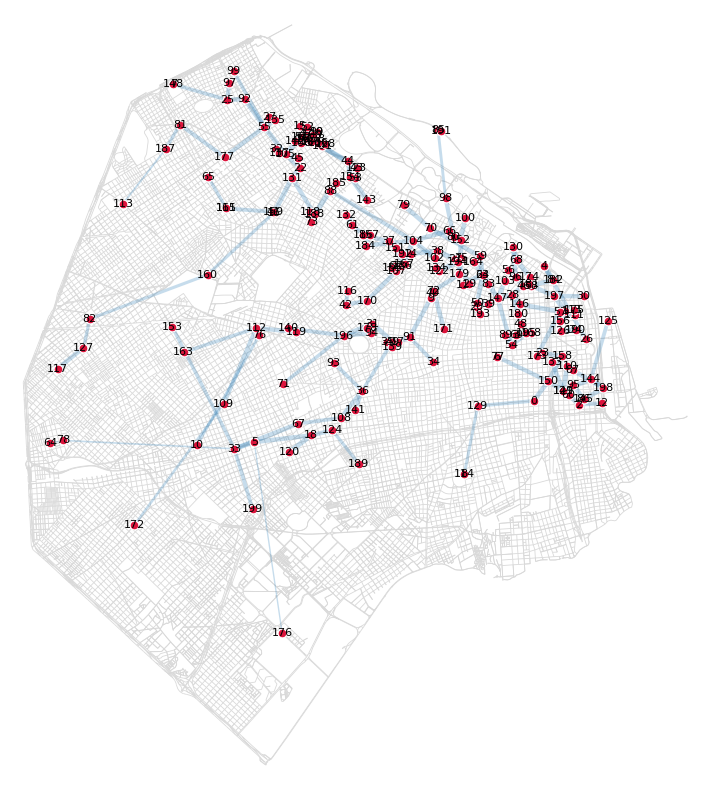

6893.002905375797


In [320]:
T, costo = prim(G)
# T, costo = kruskal(G, 2, 7)
graficar(T)
print(costo)

Con tales algoritmos es posible encontrar el camino más barato de forma *greedy* pero en tiempo **polinomial**. Sin embargo, existe un gran problema: las cafeterías se visitan más de una vez para viajar entre puntos.

## *El vendedor viajero*

Dado que sólamente tienen un transportista, requiere que les generen un plan para poder viajar por toda la ciudad de la forma más barata posible y sin pasar por la misma cafetería más de una vez.

La única restricción es que el algoritmo debe correr en menos de 30 segundos, puesto que el café no se puede enfriar. El repartidor usará el mejor camino obtenido hasta el momento.

Antes de mandar al transportista, deciden ver cómo evoluciona los costos de transporte en función del tiempo.

In [312]:
import itertools
import time


def TSP(G, start, limite=30, sample_every=1):
    """
    Recorre todas las permutaciones (fuerza bruta) partiendo/terminando en 'start'.

    Parámetros:
    ----------
    G : nx.Graph
        Grafo completo no dirigido con 'weight' en cada arista.
    start : nodo
        Nodo inicial del tour (se asume válido).
    limite : float | None
        Límite de tiempo en segundos. Si se cumple, retorna lo mejor hallado.
    sample_every : float
        Intervalo (seg) para muestrear el costo actual y registrar en historia_costos.

    Retorna:
    -------
    (ruta_graph, mejor_costo, historia_costos)
        ruta_graph : nx.Graph con las aristas de la mejor ruta hallada.
        mejor_costo : float costo total de la mejor ruta.
        historia_costos : list[tuple[float, float]] con pares (tiempo, costo).
    """

    # -----
    # Preparar nodos y solución inicial (ruta por defecto)
    # -----
    otros = [v for v in G.nodes() if v != start]
    ruta0 = [start] + otros + [start]
    costo0 = sum(G[a][b]["weight"] for a, b in zip(ruta0, ruta0[1:]))
    mejor_ruta, mejor_costo = ruta0, float(costo0)

    # -----
    # Bucle de permutaciones con muestreo temporal
    # -----
    t0 = time.time()
    next_sample = 0.0
    historia_costos = [(0.0, mejor_costo)]  # punto inicial

    for perm in itertools.permutations(otros):
        # Límite de tiempo
        elapsed = time.time() - t0
        if limite is not None and elapsed >= limite:
            break

        # Ruta y costo
        ruta = [start] + list(perm) + [start]
        costo = 0.0
        for a, b in zip(ruta, ruta[1:]):
            costo += G[a][b]["weight"]

        # Actualizar mejor solución
        if costo < mejor_costo:
            mejor_costo = costo
            mejor_ruta = ruta

        # Muestrear costo cada `sample_every` segundos
        if elapsed >= next_sample:
            historia_costos.append((elapsed, mejor_costo))
            next_sample = elapsed + sample_every

    # Asegurar último punto
    elapsed = time.time() - t0
    if not historia_costos or historia_costos[-1][0] < elapsed:
        historia_costos.append((elapsed, mejor_costo))

    # -----
    # Construir grafo de la mejor ruta (para graficar)
    # -----
    ruta_graph = nx.Graph()
    ruta_graph.add_nodes_from(G.nodes(data=True))
    for a, b in zip(mejor_ruta, mejor_ruta[1:]):
        ruta_graph.add_edge(a, b, weight=G[a][b]["weight"])

    # Copiar metadatos de posiciones si existen
    if "pos" in G.graph:
        ruta_graph.graph["pos"] = G.graph["pos"]

    return ruta_graph, mejor_costo, historia_costos


def graficarCostos(historia_costos):
    """
    Dibuja el costo mínimo encontrado en función del tiempo.
    historia_costos: lista de (tiempo_seg, costo).
    """
    tiempos = [t for t, _ in historia_costos]
    costos = [c for _, c in historia_costos]

    plt.figure()
    plt.plot(tiempos, costos, marker="o")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Costo mínimo encontrado")
    plt.title("Evolución de los costos")
    plt.grid(True)
    plt.show()

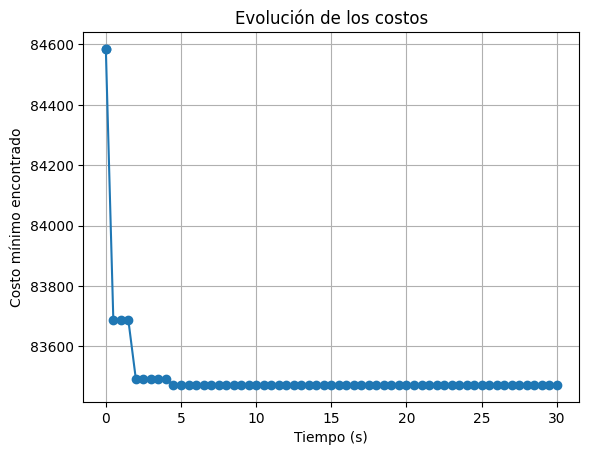

In [313]:
ruta_grafo, costo, historia = TSP(G, start=0)

graficarCostos(historia)

Tal costo es muy elevado para las finanzas de la empresa. De hecho, es un problema **NP completo**, es decir, no se resuelva de forma polinomial. 

Por lo mismo, optan por utilizar el ***Minimum Spanning Tree Heuristic***, dando la posibilidad de optar por un costo accesible en el menor tiempo posible:

1. Construir un MST del grafo $T$.
2. Visitar en **preorden** el árbol MST. Registrar, además, el orden de cada visita. Notar que **preorden** es una forma de navegar por un árbol. Esto ya viene implementado en `networkx`.
3. Tomar el orden de las primeras visitas y anexar `s` al final.

In [335]:
def TSP_heuristica(G):
    """
    Construye el MST con tu función `prim`, y busca un tour TSP heurístico
    recorriendo el MST en preorden para distintos nodos de inicio.
    Devuelve el mejor tour encontrado y la historia (tiempo, costo).

    Parámetros:
    ----------
    G : networkx.Graph
        Grafo completo con atributo 'weight' en cada arista.

    Retorna:
    -------
    (tour_graph, mejor_costo, mejor_tour, historia_costos) : tuple
        tour_graph    : nx.Graph con las aristas/pesos del mejor tour.
        mejor_costo   : float, costo del mejor tour encontrado.
        mejor_tour    : list, ciclo (incluye el inicio al final).
    """

    # -----
    # Construir el MST
    # -----
    T, _ = prim(G)
    # T, _ = kruskal(G)

    # -----
    # Crear el iterable
    # -----
    starts = list(G.nodes())

    # -----
    # 3) Inicializaciones para la historia costo-tiempo
    # -----
    next_sample = 0.0
    historia_costos = [(0.0, float("inf"))]  # punto inicial
    mejor_costo = float("inf")
    mejor_tour = None

    # -----
    # Probar cada inicio: DFS preorden sobre el MISMO MST
    # -----
    for s in starts:
        # Preorden desde s
        orden = list(nx.dfs_preorder_nodes(T, source=s))
        tour = orden + [s]  # cerrar ciclo

        # Costo usando PESOS DE G
        costo = 0.0
        for u, v in zip(tour, tour[1:]):
            costo += G[u][v]["weight"]

        # Mejor solución
        if costo < mejor_costo:
            mejor_costo = costo
            mejor_tour = tour

    # -----
    # Grafo del mejor tour para graficar
    # -----
    tour_graph = nx.Graph()
    tour_graph.add_nodes_from(G.nodes(data=True))
    for u, v in zip(mejor_tour, mejor_tour[1:]):
        tour_graph.add_edge(u, v, weight=G[u][v]["weight"])

    if "pos" in G.graph:
        tour_graph.graph["pos"] = G.graph["pos"]

    return tour_graph, float(mejor_costo), mejor_tour

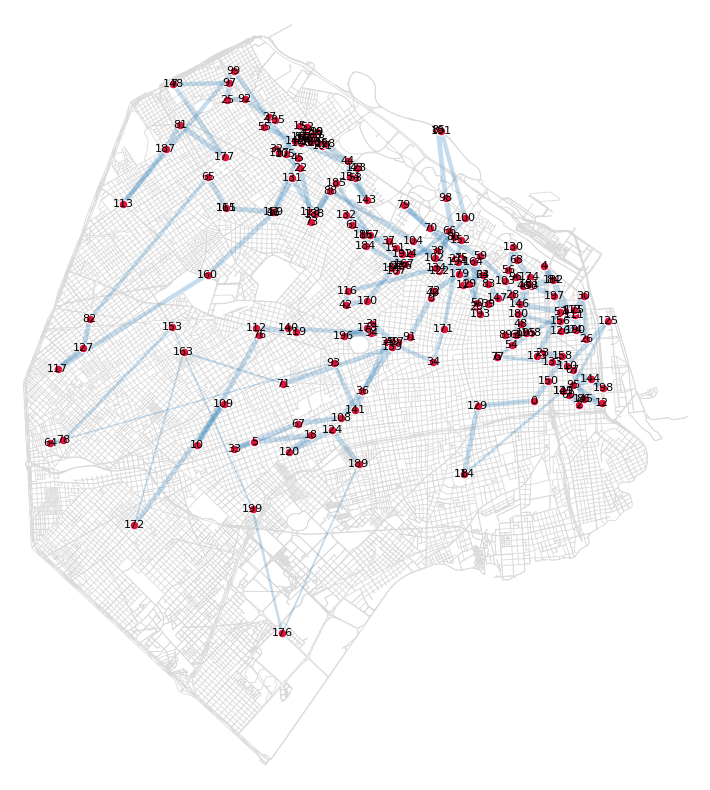

El costo es 16935.619616583954


In [339]:
optimo_heuristico, costo, tour = TSP_heuristica(G)

graficar(optimo_heuristico, labels=False)
print("El costo es", costo)

Como se puede ver, muchas veces, a pesar de no tener el costo óptimo, es preferible utilizar heurísticas que nos garanticen estar cercanos al valor idóneo. 

Estas heurísticas son utilizadas en problemas NP completos, donde el rendimiento llega a ser muy ineficiente. 

Situaciones en la vida real está lleno de heurísticas que permiten poder funcionar bajo un tiempo restricto y nos garantizan una aproximación coherente con la mejor respuesta. 

Notar que el problema de los NP-completos no sólamente está en encontrar la solución, si no que también en **probar** que se está en el óptimo. Es decir, **garantizar factibilidad es fácil, pero verificar *optimalidad* es dificil**.

Con heurísticas nos saltamos la étapa de garantizar la *optimalidad*, no obstante, intentamos garantizar una aproximación lo suficientemente buena al valor ideal.